Custom CNN

In [ ]:
import os
import json
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras

In [ ]:
#This to allow reproducibilty
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
#Access to GoogleDrive and set dataframe directory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = "/content/drive/My Drive/DeepLearning/Image Classification/MaskDataset"

In [ ]:
#Load dataset and "make" it categorical, and so following path data/training/class_1/img_1, img_2 ...
with open(os.path.join(dataset_dir,"train_gt.json")) as train_label:
    train_dict = json.load(train_label)

dataframe = pd.DataFrame(train_dict.items())
dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)
dataframe["class"] = dataframe["class"].astype(str)                             #cast "class" to string
dataframe = dataframe.sample(frac=1).reset_index(drop=True)                     #shuffle dataframe (Keras performs it after splitting so having images ordered by class is ineffective)

In [ ]:
#Data Augmentation performed on Training set
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_h = 512
img_w = 512
batch_size = 64
#This should allow us to make classes detailed with a description, but do no work :(
class_detailed = ['NO_PERSON', 
                  'ALL_PEOPLE', 
                  'SOMEONE']
training_dir = os.path.join(dataset_dir,'training')

#No zoom, rotating and anything that let image "lose information" since those transformations can modify image class
train_data_gen = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    rescale=1/255.,
                                    validation_split=0.15)

train_set_gen = train_data_gen.flow_from_dataframe(dataframe,
                                                   training_dir,
                                                   batch_size=batch_size,
                                                   target_size=(img_h, img_w),
                                                   #classes=class_detailed,
                                                   class_mode='categorical',
                                                   subset='training',
                                                   shuffle=True,
                                                   seed=SEED)

#Operating in this way Augmentation is performed only on Training data (Validation set has fresh generator)
validation_data_gen = ImageDataGenerator(rescale=1/255.,
                                         validation_split=0.15)

valid_set_gen = validation_data_gen.flow_from_dataframe(dataframe,
                                                        training_dir,
                                                        batch_size=batch_size,
                                                        target_size=(img_h, img_w),
                                                        #classes=class_detailed,
                                                        class_mode='categorical',  
                                                        subset='validation',
                                                        shuffle=True,
                                                        seed=SEED)


count = 0
for image in valid_set_gen.filenames:
  for image2 in train_set_gen.filenames:
    if(image == image2):
      count+=1
print("Common image among sets: " + str(count))         #checking for disjointness of validation and training set

count_0 = 0
count_1 = 0
count_2 = 0
for classes in valid_set_gen.classes:
  if classes == 0:
    count_0 += 1
  if classes == 1:
    count_1 += 1
  if classes == 2:
    count_2 += 1
print("Image of class 0 #" + str(count_0))
print("Image of class 1 #" + str(count_1))
print("Image of class 2 #" + str(count_2))               #checking image distribution w.r.t classes among validation set 

Found 4772 validated image filenames belonging to 3 classes.
Found 842 validated image filenames belonging to 3 classes.
Common image among sets: 0
Image of class 0 #287
Image of class 1 #278
Image of class 2 #277


In [ ]:
#Now let's shape train, validation set.
num_classes = 3

#TRAINING
training_set = tf.data.Dataset.from_generator(lambda: train_set_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, img_h,img_w,3], [None, num_classes]))
training_set = training_set.repeat()

#VALIDATION
validation_set = tf.data.Dataset.from_generator(lambda: valid_set_gen,
                                                output_types=(tf.float32, tf.float32),
                                                output_shapes=([None, img_h,img_w,3], [None, num_classes]))
validation_set = validation_set.repeat()

[]

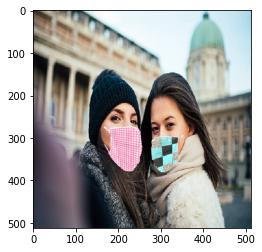

In [ ]:
#This allow us to see the images fed to our NN
import matplotlib.pyplot as plt
%matplotlib inline

iterator = iter(training_set)
augmented_img, target = next(iterator)

augmented_img = np.array(augmented_img[0])
augmented_img = augmented_img * 255

plt.imshow(np.uint8(augmented_img))
plt.plot()

In [ ]:
# Architecture: Features extraction -> Classifier
start_f = 16
depth = 5

model = tf.keras.Sequential()

# Features extraction
for i in range(depth):

    if i == 0:
        input_shape = [img_h, img_w, 3]
    else:
        input_shape=[None]

    # Conv block: Conv2D -> Activation -> Pooling
    model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                     kernel_size=(3, 3),
                                     strides=(1, 1),
                                     use_bias=True,
                                     padding='same',
                                     input_shape=input_shape))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    start_f *= 2
    
# Classifier
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 16)      448       
_________________________________________________________________
re_lu (ReLU)                 (None, 512, 512, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
callbacks = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks.append(es_callback)

In [ ]:
history = model.fit(x=training_set,
                    epochs=100,
                    steps_per_epoch=len(train_set_gen),
                    validation_data=validation_set,
                    validation_steps=len(valid_set_gen),
                    callbacks=callbacks)

Epoch 1/100
38/38 [==============================] - 2165s 57s/step - loss: 1.2132 - accuracy: 0.3374 - val_loss: 1.0985 - val_accuracy: 0.3409
Epoch 2/100
38/38 [==============================] - 94s 2s/step - loss: 1.0985 - accuracy: 0.3374 - val_loss: 1.0985 - val_accuracy: 0.3717
Epoch 3/100
38/38 [==============================] - 94s 2s/step - loss: 1.0984 - accuracy: 0.3458 - val_loss: 1.0985 - val_accuracy: 0.3325
Epoch 4/100
38/38 [==============================] - 95s 2s/step - loss: 1.0949 - accuracy: 0.3741 - val_loss: 1.0850 - val_accuracy: 0.3836
Epoch 5/100
38/38 [==============================] - 94s 2s/step - loss: 1.0631 - accuracy: 0.4346 - val_loss: 1.0483 - val_accuracy: 0.4359
Epoch 6/100
38/38 [==============================] - 95s 3s/step - loss: 1.0218 - accuracy: 0.4935 - val_loss: 1.0589 - val_accuracy: 0.4608
Epoch 7/100
38/38 [==============================] - 96s 3s/step - loss: 0.9365 - accuracy: 0.5488 - val_loss: 0.8505 - val_accuracy: 0.5855
Epoch 8/10

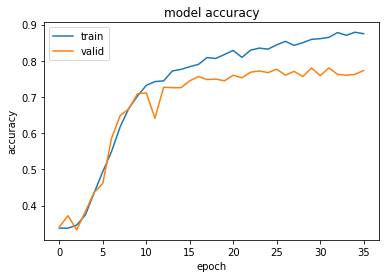

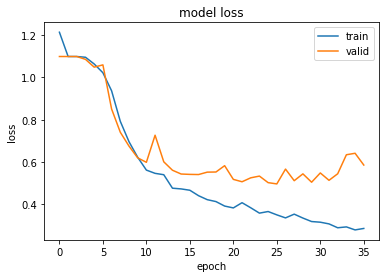

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
from PIL import Image

dataset_dir_test = os.path.join(dataset_dir,"test") #Path di questo tipo /content/drive/My Drive/DeepLearning/Image Classification/MaskDataset/test
image_filenames = next(os.walk(dataset_dir_test))[2]

results = {}
for image_name in image_filenames:

  img = Image.open(os.path.join(dataset_dir_test, image_name)).convert('RGB')
  img = img.resize((img_h,img_w))
  img_array = np.array(img)
  img_array = np.expand_dims(img_array, 0) 
  img_array = img_array.astype('float32')
  img_array /= 255.0 #Data Normalization

  prediction = model.predict(img_array)
  results[image_name] = np.argmax(np.matrix(prediction))

create_csv(results, os.path.join(dataset_dir,"Results/Comune"))